# Spatial-IT RRMap OT Analysis

This notebook analyzes timepoint transitions in an `AnnData` object using the OT workflow in `rrmap_ot.py`.

## Objective
- Compute transitions between consecutive `course` labels.
- Compare source-to-destination `anno_L2` state flow.
- Review QC diagnostics (entropy + mass diagnostics for unbalanced OT).


In [1]:
from __future__ import annotations

from pathlib import Path
import os
import sys
import warnings

# Avoid cache issues in read-only/home-restricted environments
NOTEBOOK_TMP = Path.cwd().resolve() / "tmp"
os.environ.setdefault("MPLCONFIGDIR", str(NOTEBOOK_TMP / "matplotlib"))
os.environ.setdefault("NUMBA_CACHE_DIR", str(NOTEBOOK_TMP / "numba_cache"))
Path(os.environ["MPLCONFIGDIR"]).mkdir(parents=True, exist_ok=True)
Path(os.environ["NUMBA_CACHE_DIR"]).mkdir(parents=True, exist_ok=True)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scanpy as sc
from IPython.display import display

# Reproducibility
SEED = 0
np.random.seed(SEED)

# Resolve repo root even when Jupyter starts from a subdirectory
def find_project_root(start: Path, marker: str = "rrmap_ot.py") -> Path:
    for candidate in [start.resolve(), *start.resolve().parents]:
        if (candidate / marker).exists():
            return candidate
    raise FileNotFoundError(
        f"Could not find {marker} by walking up from {start.resolve()}."
    )

PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import rrmap_ot

print(f"Notebook cwd: {Path.cwd().resolve()}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Using rrmap_ot from: {Path(rrmap_ot.__file__).resolve()}")


Notebook cwd: /Users/christoffer/work/karolinska/development/spatial-OT/output/jupyter-notebook
Project root: /Users/christoffer/work/karolinska/development/spatial-OT
Using rrmap_ot from: /Users/christoffer/work/karolinska/development/spatial-OT/rrmap_ot.py


## Configuration

Set `ADATA_PATH` to your RRMap / Spatial-IT `.h5ad` file.

Defaults here use unbalanced centroid OT (recommended first pass for large datasets).


In [2]:
# ---- User configuration ----
ADATA_PATH = Path("/Volumes/processing2/RRmap/data/RRmap_metadata_fixed_update.h5ad")

COURSE_KEY = "course"
STATE_KEY = "anno_L2"
EMBEDDING_KEY = None  # None => rrmap_ot fallback: X_scVI -> X_umap -> X_pca

# Run one model at a time to avoid cross-model transitions.
MODELS = {
    "Chronic": {
        "baseline": "MOG CFA",
        "courses": ["MOG CFA", "non symptomatic", "early onset", "chronic peak", "chronic long"],
    },
    "RR": {
        "baseline": "PLP CFA",
        "courses": [
            "PLP CFA", "onset I", "onset II", "monophasic",
            "peak I", "remitt I", "peak II", "remitt II", "peak III",
        ],
    },
}
MODEL_NAME = "Chronic"  # "Chronic", "RR", or None for full-dataset run
STRIP_COURSE_LABELS = True
COURSE_ORDER = None  # Used only when MODEL_NAME is None

METHOD = "unbalanced"  # "balanced" or "unbalanced"
MODE = "centroid"      # "centroid" (fast) or "cell" (heavy)
REG = 0.05
REG_M = 10.0
MAX_CELLS_PER_COURSE = 20_000
UNBALANCED_MASS_MODE = "normalized"  # "normalized" or "raw"
INCLUDE_ALL_STATES = False
RANDOM_STATE = 0

TOP_K = 3


In [3]:
# Load adata
if "adata" in globals() and hasattr(adata, "obs"):
    print("Using existing `adata` already present in notebook session.")
else:
    if not ADATA_PATH.exists():
        raise FileNotFoundError(
            f"ADATA_PATH does not exist: {ADATA_PATH}\n"
            "Set ADATA_PATH in the config cell to your .h5ad file."
        )
    adata = sc.read_h5ad(ADATA_PATH)

print(adata)


AnnData object with n_obs × n_vars = 877141 × 5101
    obs: 'cell', 'centroid_x', 'centroid_y', 'centroid_z', 'component', 'volume', 'surface_area', 'scale', 'region', 'sample_id', 'proseg_cluster', 'output_folder', 'Num', 'n_genes', 'n_counts', 'louvain_0.5', 'louvain_1', 'louvain_1.5', 'louvain_2', 'louvain_2.5', 'louvain_3', 'louvain_3.5', 'Cluster', 'Level1', 'Level2', 'Level3', 'Level3.1', 'grid_label', 'rbd_domain', 'rbd_domain_0.1', 'rbd_domain_0.2', 'rbd_domain_0.3', 'rbd_domain_0.5', 'rbd_domain_0.6', 'rbd_domain_0.7', 'rbd_domain_0.8', 'rbd_domain_0.9', 'rbd_domain_1.1', 'rbd_domain_1', 'rbd_domain_1.25', 'rbd_domain_1.4', 'rbd_domain_1.5', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'leiden_3.5', 'sample_name', 'course', 'condition', 'model', 'cytetype_annotation_louvain_3.5', 'cytetype_cellOntologyTerm_louvain_3.5', 'cluster_id', 'author_label', 'annotation', 'Class', 'state', 'CL_term', 'CL_term_id', 'confidence', 'author_label_similarity_

In [4]:
# Basic validation and quick summary
required_obs = [COURSE_KEY, STATE_KEY]
missing_obs = [k for k in required_obs if k not in adata.obs]
if missing_obs:
    raise KeyError(f"Missing required obs keys: {missing_obs}")

print("Required obs keys present.")
print(f"Available embeddings in adata.obsm: {list(adata.obsm.keys())}")

print("\nCells per course (raw labels):")
display(adata.obs[COURSE_KEY].value_counts(dropna=False).rename("n_cells").to_frame())

if STRIP_COURSE_LABELS:
    course_raw = adata.obs[COURSE_KEY].astype("string")
    course_clean = course_raw.str.strip()
    n_changed = int((course_raw != course_clean).fillna(False).sum())
    if n_changed > 0:
        print(f"\nDetected {n_changed} cells with leading/trailing spaces in `{COURSE_KEY}` labels.")
        print("Cells per course (stripped labels):")
        display(course_clean.value_counts(dropna=False).rename("n_cells").to_frame())

print("\nCells per state (top 20):")
display(adata.obs[STATE_KEY].value_counts(dropna=False).head(20).rename("n_cells").to_frame())


Required obs keys present.
Available embeddings in adata.obsm: ['X_mana_gauss', 'X_mana_gauss_2neigh', 'X_pca', 'X_scVI', 'X_umap', 'spatial']

Cells per course (raw labels):


,n_cells
course,
peak III,108344
peak I,105761
monophasic,93898
chronic long,78239
remitt I,71522
peak II,70152
chronic peak,65703
PLP CFA,59168
early onset,58116



Cells per state (top 20):


,n_cells
anno_L2,
Oligodendrocyte,174835
Interneuron,130506
Microglia,103816
Astrocyte,102125
Endothelial,60810
Meningeal fibroblast,42899
Macrophage,42745
Neuron,39572
T cell,31211


## Compute OT Transitions

Runs `compute_ot_transitions(...)` from `rrmap_ot.py` and stores outputs in `adata.uns["ot_transitions"]`.


In [5]:
course_key_for_ot = COURSE_KEY
if STRIP_COURSE_LABELS:
    course_key_for_ot = f"{COURSE_KEY}__stripped"
    adata.obs[course_key_for_ot] = adata.obs[COURSE_KEY].astype("string").str.strip()

adata_for_ot = adata
course_order_for_ot = COURSE_ORDER

if MODEL_NAME is not None:
    if MODEL_NAME not in MODELS:
        raise KeyError(f"MODEL_NAME={MODEL_NAME!r} not found in MODELS: {list(MODELS.keys())}")

    model_cfg = MODELS[MODEL_NAME]
    model_courses = [str(c).strip() for c in model_cfg["courses"]]
    baseline = str(model_cfg.get("baseline", model_courses[0])).strip()
    if model_courses and baseline != model_courses[0]:
        warnings.warn(
            f"Model {MODEL_NAME!r} baseline {baseline!r} does not match first course {model_courses[0]!r}."
        )

    model_mask = adata.obs[course_key_for_ot].isin(model_courses).to_numpy()
    if int(model_mask.sum()) == 0:
        raise ValueError(
            f"No cells matched MODEL_NAME={MODEL_NAME!r} using course labels: {model_courses}"
        )

    adata_for_ot = adata[model_mask].copy()
    course_order_for_ot = model_courses

    present = set(adata_for_ot.obs[course_key_for_ot].dropna().unique().tolist())
    missing_courses = [c for c in model_courses if c not in present]
    if missing_courses:
        warnings.warn(
            f"Some configured courses are missing for MODEL_NAME={MODEL_NAME!r}: {missing_courses}"
        )

    print(f"Running model: {MODEL_NAME}")
    print(f"Course order: {course_order_for_ot}")
    print(f"Cells in model subset: {adata_for_ot.n_obs:,}")
else:
    print("Running full dataset (MODEL_NAME=None).")
    if course_order_for_ot is not None:
        print(f"Using explicit COURSE_ORDER with {len(course_order_for_ot)} labels.")

transitions, plans = rrmap_ot.compute_ot_transitions(
    adata=adata_for_ot,
    course_key=course_key_for_ot,
    state_key=STATE_KEY,
    embedding_key=EMBEDDING_KEY,
    method=METHOD,
    mode=MODE,
    course_order=course_order_for_ot,
    reg=REG,
    reg_m=REG_M,
    max_cells_per_course=MAX_CELLS_PER_COURSE,
    random_state=RANDOM_STATE,
    return_plans=True,
    include_all_states=INCLUDE_ALL_STATES,
    unbalanced_mass_mode=UNBALANCED_MASS_MODE,
)

print(f"Computed {len(transitions)} course-pair transition matrix/matrices.")
print("Pairs:", list(transitions.keys()))


Running model: Chronic
Course order: ['MOG CFA', 'non symptomatic', 'early onset', 'chronic peak', 'chronic long']
Cells in model subset: 268,712
Computed 4 course-pair transition matrix/matrices.
Pairs: [('MOG CFA', 'non symptomatic'), ('non symptomatic', 'early onset'), ('early onset', 'chronic peak'), ('chronic peak', 'chronic long')]


In [6]:
# Inspect top-k destinations per source state for each course pair
all_top_tables = {}

for pair, t_df in transitions.items():
    top = rrmap_ot.top_k_destinations(t_df, k=TOP_K, normalize_rows=True)

    rows = []
    for src_state, dsts in top.items():
        for rank, (dst_state, score) in enumerate(dsts, start=1):
            rows.append(
                {
                    "pair": f"{pair[0]}->{pair[1]}",
                    "source_state": src_state,
                    "rank": rank,
                    "dest_state": dst_state,
                    "score": score,
                }
            )

    top_df = pd.DataFrame(rows)
    all_top_tables[pair] = top_df

    print(f"\nTop transitions for {pair[0]} -> {pair[1]}")
    if top_df.empty:
        print("No positive mass transitions.")
    else:
        display(top_df.sort_values(["source_state", "rank"]).head(30))



Top transitions for MOG CFA -> non symptomatic


,pair,source_state,rank,dest_state,score
0,MOG CFA->non symptomatic,Arachnoid barrier,1,Arachnoid barrier,0.472545
1,MOG CFA->non symptomatic,Arachnoid barrier,2,Meningeal fibroblast,0.294927
2,MOG CFA->non symptomatic,Arachnoid barrier,3,Interneuron,0.215907
3,MOG CFA->non symptomatic,Artifact,1,Interneuron,0.728937
4,MOG CFA->non symptomatic,Artifact,2,Astrocyte,0.135122
5,MOG CFA->non symptomatic,Artifact,3,Artifact,0.107067
6,MOG CFA->non symptomatic,Astrocyte,1,Astrocyte,0.999940
7,MOG CFA->non symptomatic,Astrocyte,2,Interneuron,0.000054
8,MOG CFA->non symptomatic,Astrocyte,3,Oligodendrocyte,0.000006
9,MOG CFA->non symptomatic,B cell,1,B cell,0.975771



Top transitions for non symptomatic -> early onset


,pair,source_state,rank,dest_state,score
0,non symptomatic->early onset,Arachnoid barrier,1,Arachnoid barrier,9.999944e-01
1,non symptomatic->early onset,Arachnoid barrier,2,Meningeal fibroblast,5.083304e-06
2,non symptomatic->early onset,Arachnoid barrier,3,Monocyte-derived,3.363470e-07
3,non symptomatic->early onset,Artifact,1,Schwann cell,8.264290e-01
4,non symptomatic->early onset,Artifact,2,Artifact,1.625924e-01
5,non symptomatic->early onset,Artifact,3,Macrophage,7.139530e-03
6,non symptomatic->early onset,Astrocyte,1,Astrocyte,9.572958e-01
7,non symptomatic->early onset,Astrocyte,2,Microglia,2.334415e-02
8,non symptomatic->early onset,Astrocyte,3,Artifact,7.514519e-03
9,non symptomatic->early onset,B cell,1,B cell,9.997273e-01



Top transitions for early onset -> chronic peak


,pair,source_state,rank,dest_state,score
0,early onset->chronic peak,Arachnoid barrier,1,Arachnoid barrier,9.998543e-01
1,early onset->chronic peak,Arachnoid barrier,2,Meningeal fibroblast,1.384373e-04
2,early onset->chronic peak,Arachnoid barrier,3,Monocyte-derived,4.132426e-06
3,early onset->chronic peak,Artifact,1,Artifact,6.662861e-01
4,early onset->chronic peak,Artifact,2,Macrophage,1.268244e-01
5,early onset->chronic peak,Artifact,3,T cell,1.047392e-01
6,early onset->chronic peak,Astrocyte,1,Astrocyte,9.000199e-01
7,early onset->chronic peak,Astrocyte,2,Microglia,7.699669e-02
8,early onset->chronic peak,Astrocyte,3,T cell,9.443124e-03
9,early onset->chronic peak,B cell,1,B cell,9.998759e-01



Top transitions for chronic peak -> chronic long


,pair,source_state,rank,dest_state,score
0,chronic peak->chronic long,Arachnoid barrier,1,Arachnoid barrier,9.999995e-01
1,chronic peak->chronic long,Arachnoid barrier,2,Meningeal fibroblast,5.417187e-07
2,chronic peak->chronic long,Arachnoid barrier,3,VSMC,1.747550e-09
3,chronic peak->chronic long,Artifact,1,Artifact,6.073235e-01
4,chronic peak->chronic long,Artifact,2,Schwann cell,2.498392e-01
5,chronic peak->chronic long,Artifact,3,Interneuron,5.745995e-02
6,chronic peak->chronic long,Astrocyte,1,Astrocyte,9.935392e-01
7,chronic peak->chronic long,Astrocyte,2,Oligodendrocyte,5.235870e-03
8,chronic peak->chronic long,Astrocyte,3,Interneuron,4.720476e-04
9,chronic peak->chronic long,B cell,1,B cell,9.999240e-01


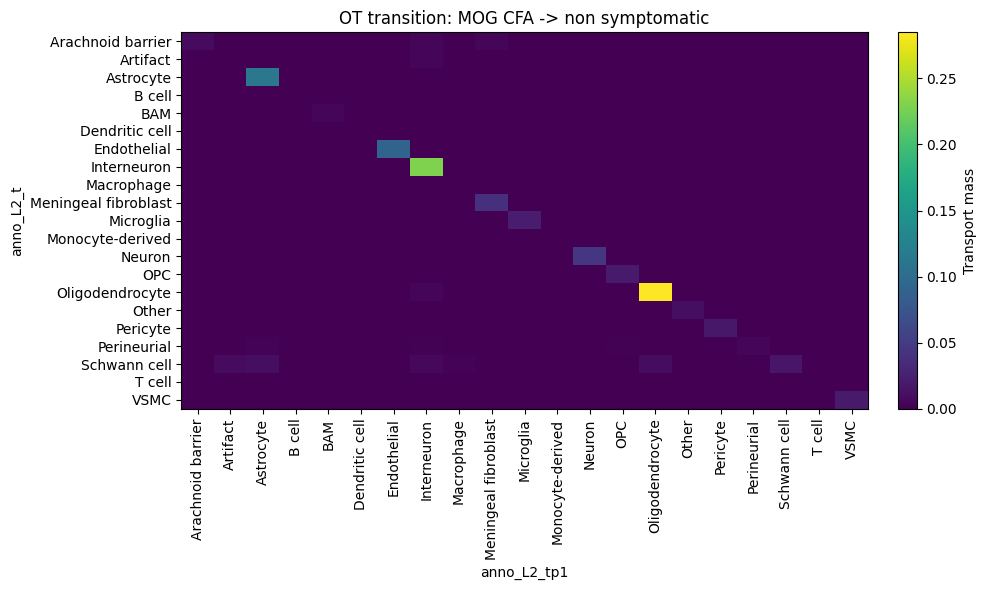

In [13]:
# Plot one heatmap
if not transitions:
    raise ValueError("No transitions were computed. Check course ordering and required keys.")

pair_to_plot = next(iter(transitions.keys()))
t_plot = transitions[pair_to_plot]

ax = rrmap_ot.plot_transition_heatmap(
    t_plot,
    title=f"OT transition: {pair_to_plot[0]} -> {pair_to_plot[1]}",
    figsize=(10, 6),
    cmap="viridis",
)
plt.tight_layout()
plt.show()


In [14]:
# QC: outgoing entropy + unbalanced mass diagnostics for one pair
pair_qc = next(iter(transitions.keys()))
t_qc = transitions[pair_qc]

entropy = rrmap_ot.outgoing_entropy(t_qc).sort_values(ascending=False)
print(f"Outgoing entropy ({pair_qc[0]} -> {pair_qc[1]})")
display(entropy.to_frame().head(30))

if METHOD == "unbalanced":
    payload = plans[pair_qc]
    source_labels = payload.get("source_labels")
    target_labels = payload.get("target_labels")

    diag = rrmap_ot.unbalanced_mass_diagnostics(
        plan=payload["plan"],
        a=payload["a"],
        b=payload["b"],
        source_labels=source_labels,
        target_labels=target_labels,
    )

    print("Unbalanced mass summary:")
    display(pd.Series(diag["summary"], name="value").to_frame())

    print("Source mass diagnostics (head):")
    display(diag["source"].head(20))

    print("Target mass diagnostics (head):")
    display(diag["target"].head(20))


Outgoing entropy (MOG CFA -> non symptomatic)


,outgoing_entropy
anno_L2_t,
Schwann cell,2.544509e+00
Perineurial,2.209248e+00
Arachnoid barrier,1.621294e+00
Artifact,1.256385e+00
BAM,1.147822e+00
Macrophage,1.067415e+00
T cell,5.638998e-01
B cell,1.646121e-01
Oligodendrocyte,1.371917e-01


Unbalanced mass summary:


,value
total_a,1.000000
total_b,1.000000
transported_mass,0.992072
source_l1_deviation,0.017092
target_l1_deviation,0.013098


Source mass diagnostics (head):


,a,row_sum,difference,ratio
source,,,,
Arachnoid barrier,0.018280,0.017130,-0.001151,0.937064
Artifact,0.005870,0.005716,-0.000154,0.973793
Astrocyte,0.111499,0.112265,0.000766,1.006868
B cell,0.000084,0.000080,-0.000003,0.959270
BAM,0.007100,0.006726,-0.000374,0.947291
Dendritic cell,0.000140,0.000139,-0.000001,0.992392
Endothelial,0.092800,0.091377,-0.001423,0.984670
Interneuron,0.225375,0.228372,0.002997,1.013300
Macrophage,0.001426,0.001396,-0.000030,0.979287


Target mass diagnostics (head):


,b,col_sum,difference,ratio
target,,,,
Arachnoid barrier,0.007773,0.008095,0.000322,1.041445
Artifact,0.008776,0.008837,0.000060,1.006843
Astrocyte,0.130643,0.128335,-0.002308,0.982331
B cell,0.000162,0.000156,-0.000006,0.961559
BAM,0.004955,0.005093,0.000138,1.027781
Dendritic cell,0.000939,0.000858,-0.000081,0.913748
Endothelial,0.091100,0.091333,0.000232,1.002549
Interneuron,0.253190,0.247963,-0.005227,0.979354
Macrophage,0.002882,0.002867,-0.000015,0.994693


In [15]:
# Optional: save transition matrices and top tables for downstream review
run_label = (MODEL_NAME if MODEL_NAME is not None else "full_dataset").replace(" ", "_")
out_dir = PROJECT_ROOT / "output" / "ot_transition_tables" / run_label
out_dir.mkdir(parents=True, exist_ok=True)

for pair, t_df in transitions.items():
    pair_str = f"{pair[0]}__to__{pair[1]}".replace("/", "-")
    t_df.to_csv(out_dir / f"transition_{pair_str}.csv")

for pair, top_df in all_top_tables.items():
    pair_str = f"{pair[0]}__to__{pair[1]}".replace("/", "-")
    top_df.to_csv(out_dir / f"topk_{pair_str}.csv", index=False)

print(f"Saved tables to: {out_dir}")


Saved tables to: /Users/christoffer/work/karolinska/development/spatial-OT/output/ot_transition_tables/Chronic


In [ ]:
# Optional heavy run (cell mode): uncomment when needed
# transitions_cell = rrmap_ot.compute_ot_transitions(
#     adata=adata,
#     course_key=COURSE_KEY,
#     state_key=STATE_KEY,
#     embedding_key=EMBEDDING_KEY,
#     method=METHOD,
#     mode="cell",
#     course_order=COURSE_ORDER,
#     reg=REG,
#     reg_m=REG_M,
#     max_cells_per_course=5_000,
#     random_state=RANDOM_STATE,
#     include_all_states=INCLUDE_ALL_STATES,
#     unbalanced_mass_mode=UNBALANCED_MASS_MODE,
# )
# print("Cell-mode pairs:", list(transitions_cell.keys()))


# Optimal Transport Transitions — Chronic EAE Model  
## Lesion Ecology Interpretation

Timepoints modeled:

- MOG CFA → Non-symptomatic  
- Non-symptomatic → Early onset  
- Early onset → Chronic peak  
- Chronic peak → Chronic long  

This analysis captures the transition from:

Induction → Preclinical → Early disease → Chronic inflammation → Chronic remodeling

---

# 1️⃣ Global structural scaffold

Across all transitions, structural compartments remain highly stable:

- Arachnoid barrier → Arachnoid barrier  
- Meningeal fibroblast → Meningeal fibroblast  
- Endothelial → Endothelial  
- Astrocyte → Astrocyte  
- Neurons → Neurons  

**Interpretation**

These represent anatomical tissue infrastructure rather than dynamic inflammatory states.

---

# 2️⃣ Induction → Preclinical phase  
## MOG CFA → Non-symptomatic

### Barrier remodeling begins

Key flows:

- Arachnoid barrier → Fibroblast (0.29)  
- Arachnoid barrier → Interneuron (0.22) ⚠️  

**Interpretation**

Early meningeal remodeling following CFA immunization.  
Neuronal transitions reflect adjacency, not fate.

---

### Border macrophage redistribution

- BAM → BAM (0.76)  
- BAM → Fibroblast (0.13)  
- BAM → Microglia (0.09)

**Interpretation**

Border macrophages expand locally and begin interfacing with structural niches.

---

### Macrophage reclassification

- Macrophage → Monocyte-derived (0.77)

**Interpretation**

Indicates early infiltration and recruitment of peripheral monocytes even before symptoms.

---

# 3️⃣ Preclinical → Early onset  
## Non-symptomatic → Early onset

### Myeloid infiltration accelerates

- Macrophage → Monocyte-derived (0.90)  
- Dendritic → Monocyte-derived (0.31)

**Interpretation**

Strong recruitment of peripheral immune cells marks clinical onset.

---

### Astrocyte activation emerges

- Astrocyte → Astrocyte (0.96)  
- Astrocyte → Microglia (0.02)

Reflects astrocyte–microglia coupling at lesion initiation.

---

### Vascular–immune coupling begins

- Endothelial → Macrophage (0.02)  
- Endothelial → Schwann cell (0.02)

Suggests immune trafficking through vascular interfaces.

---

# 4️⃣ Early disease → Chronic peak  
## Early onset → Chronic peak

### Macrophage expansion stabilizes

- Macrophage → Macrophage (0.98)

Inflammation becomes self-sustaining.

---

### Astrocyte inflammatory coupling increases

- Astrocyte → Microglia (0.08)

Indicates glial crosstalk during peak disease.

---

### Neuronal adjacency increases

- Interneuron → Microglia (0.16)  
- Interneuron → Macrophage (0.16)

Reflects inflammatory proximity to neuronal compartments.

---

### Vascular immune interface intensifies

- Endothelial → Macrophage (0.07)  
- Endothelial → T cell (0.06)

Suggests vascular immune recruitment.

---

# 5️⃣ Chronic peak → Chronic long  
## Transition to long-term chronic remodeling

This is where chronic disease diverges from relapsing models.

---

## Barrier fibrosis and remodeling

- BAM → Fibroblast (0.36)  
- Fibroblast → Barrier (0.03)

Indicates fibrotic reinforcement of meningeal interfaces.

---

## Astrocyte scarring / gliosis

- Astrocyte → Astrocyte (0.99)  
- Astrocyte → Oligodendrocyte (0.005)

Stable astrocytic scar formation.

---

## Myeloid redistribution

- Macrophage → Macrophage (0.18)  
- Macrophage → Interneuron (0.22) ⚠️  
- Macrophage → Barrier (0.13)

Interpretation:

Inflammatory macrophages retract toward structural and neuronal niches.

---

## Dendritic diversification

- Dendritic → Interneuron (0.23) ⚠️  
- Dendritic → Oligodendrocyte (0.16) ⚠️  

Adjacency signal — reflects chronic niche mixing.

---

# 6️⃣ Chronic lesion ecology model

## Induction phase
- Border macrophage activation  
- Early monocyte recruitment  
- Barrier remodeling begins  

## Early disease
- Peripheral immune infiltration  
- Astrocyte activation  
- Vascular immune coupling  

## Chronic peak
- Self-sustaining macrophage inflammation  
- Glial activation  
- Neuronal adjacency to immune niches  

## Chronic long
- Fibrotic meningeal remodeling  
- Astrocytic scar stabilization  
- Immune redistribution rather than expansion  

---

# 7️⃣ Biological vs adjacency transitions

## Likely biological transitions

- Macrophage → Monocyte-derived  
- BAM → Fibroblast  
- Astrocyte → Microglia coupling  
- Endothelial → Immune recruitment  

## Likely spatial adjacency artifacts

- Macrophage → Neuron  
- Dendritic → Neuron  
- Fibroblast → Neuron  
- Artifact → Multiple states  

---

# 8️⃣ Chronic vs relapsing comparison insight

| Feature | Relapsing model | Chronic model |
|--------|-----------------|---------------|
| Macrophage expansion | Cyclic | Sustained |
| Barrier remodeling | Reversible | Fibrotic |
| Astrocyte response | Dynamic | Scar-stabilized |
| Immune redistribution | Between relapses | Toward structural niches |

---

# One-line conclusion

**Chronic EAE transitions reflect sustained myeloid inflammation layered onto progressive meningeal fibrosis and astrocytic scar stabilization, rather than cyclical immune reactivation.**

## Next Steps
- Compare `METHOD="balanced"` vs `METHOD="unbalanced"` and inspect how entropy changes.
- Provide an explicit `COURSE_ORDER` if lexical sorting does not match biological time.
- If centroid mode is too coarse, run cell mode on selected course pairs with lower `max_cells_per_course`.
